# Part C

## Modelling over actual clusters' mass distribution

In [1]:
%pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from subprocess import run
import os
import mesa_reader
import multiprocessing as mp

In [3]:

def salpeter_imf(mass_min, mass_max, num_stars):
    """Generate masses following Salpeter IMF: dN/dM ∝ M^(-2.35)"""
    alpha = -2.35
    u = np.random.random(num_stars)
    alpha1 = alpha + 1
    m1 = mass_min**alpha1
    m2 = mass_max**alpha1
    masses = (m1 + (m2 - m1)*u)**(1/alpha1)
    return masses

In [4]:
def inlist_pgstar(mass):
    return f"""
&pgstar
  ! see star/defaults/pgstar.defaults

  ! MESA uses PGPLOT for live plotting and gives the user a tremendous
  ! amount of control of the presentation of the information.

  ! show HR diagram
  ! this plots the history of L,Teff over many timesteps

    TRho_Profile_win_width = 6
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_win_flag = .true.
    TRho_Profile_file_flag = .true.
    TRho_Profile_file_dir = 'pgstar_out_{mass}'
    TRho_Profile_file_prefix = 'trho_pgstar_{mass}'
    TRho_Profile_file_interval = 50
    TRho_Profile_win_width = 9
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_title = 'TRho'


  ! set static plot bounds
    HR_logT_min = 3.5
    HR_logT_max = 4.6
    HR_logL_min = 2.0
    HR_logL_max = 6.0

  ! set window size (aspect_ratio = height/width)
    HR_win_width = 6
    HR_win_aspect_ratio = 1.0
    HR_win_flag = .true.
    HR_file_flag = .true.
    HR_file_dir = 'pgstar_out_{mass}'
    HR_file_prefix = 'hr_pgstar_{mass}'
    HR_file_interval = 50
    HR_win_width = 9
    HR_win_aspect_ratio = 1.0
    HR_title = 'HR'



  ! show temperature/density profile
  ! this plots the internal structure at single timestep
    TRho_Profile_win_flag = .true.

  ! add legend explaining colors
    show_TRho_Profile_legend = .true.

  ! display numerical info about the star
    show_TRho_Profile_text_info = .true.

  ! set window size (aspect_ratio = height/width)
    TRho_Profile_win_width = 8
    TRho_Profile_win_aspect_ratio = 0.75

/ ! end of pgstar namelist
"""


def inlist_project(mass):
    return f"""
&star_job

    create_pre_main_sequence_model = .true.

    save_model_when_terminate = .false.
    save_model_filename = '15M_at_TAMS.mod'

    pgstar_flag = .true.

/ 


&kap
  use_Type2_opacities = .true.
  Zbase = 0.02

/

&controls
    initial_mass = {mass} ! in Msun units
    initial_z = 0.02

    Lnuc_div_L_zams_limit = 0.99d0
    stop_near_zams = .true.

    xa_central_lower_limit_species(1) = 'h1'
    xa_central_lower_limit(1) = 1d-3

     energy_eqn_option = 'dedt'
     use_gold_tolerances = .true.


/
"""

In [ ]:
mass_l_t = dict()
results = []

def run_mesa_model(masses):
    for mass in masses:
        """Run MESA for a single mass"""
        print(f"FOR MASS: {mass}")
        
        with open('star/inlist_pgstar', 'w') as f:
            f.write(inlist_pgstar(mass))
        
        with open('star/inlist_project', 'w') as f:
            f.write(inlist_project(mass))
        
        run(['pwd'], check=True)
        run(['ls'], check=True)
        os.chdir("./star")
        run(['pwd'], check=True)
        run(['./mk'], check=True)
        run(['./rn'], check=True)
        os.chdir("../")
        
        if os.path.exists('star/LOGS/history.data'):
            results.append({'mass': mass, 'success': True})
        else:
            results.append({'mass': mass, 'success': False})

        mr = mesa_reader.MesaData(file_name='./star/LOGS/history.data')
        mass_l_t[mass] = (mr.log_L, mr.log_Teff)



  

In [6]:
def plot_hr_diagram(masses):
    """Plot HR diagram for all stars in the same plot"""
    plt.figure()
    for mass in masses:
        plt.plot(mass_l_t[mass][1], mass_l_t[mass][0], label=f'{mass:.2f} Msun')
    plt.gca().invert_xaxis()
    plt.xlabel('log(Teff)')
    plt.ylabel('log(L)')
    plt.legend()
    plt.show()

## Cluster M44

FOR MASS: 1.2683450998070074
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
partC.ipynb
report.tex
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 12:45:44
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.592220   4675.044  -5.338767  -5.338767   1.268345   1.268345   0.700000   0.001010   0.280000  -4.654878    693      0
-4.8416E+00   6.592220   0.401225 -99.000000  -6.736575 -99.000000   0.000000   0.280000   0.009381   0.020000   0.061092      2
 3.6400E-05  -0.156379   0.436287 -20.771070 -99.000000  -7.000607   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.592220   4675.031  -5.338767  -5.338767   1.268345   1.268345   0.700000   0.001010   0.280000  -4.654878    693      0
-4.7625E+00   6.592220   0.401225 -99.000000  -6.736575 -99.000000   0.000000   0.280000   0.009381   0.020000   0.061092      2
 5.3680E-05  -0.156379   0.436282 -21.072100 -99.000000  -7.000605   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.592220   4675.017  -5.338767  -5.338767   1.268345   1.268345   0.700000   0.001010   0.280000  -4.654878    693      0
-4.6833E+00   6.592220   0.401225 -99.000000  -6.736575 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 13:01:29
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.607606   4398.056  -5.087608  -5.087608   1.000565   1.000565   0.700000   0.001010   0.280000  -4.134005    701      0
-4.8416E+00   6.607606   0.283392 -99.000000  -6.485371 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071346      2
 3.6400E-05   0.091946   0.094521 -20.771070 -99.000000  -6.842888   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.607606   4398.047  -5.087608  -5.087608   1.000565   1.000565   0.700000   0.001010   0.280000  -4.134005    701      0
-4.7625E+00   6.607606   0.283392 -99.000000  -6.485371 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071346      2
 5.3680E-05   0.091946   0.094517 -99.000000 -99.000000  -6.842884   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.607606   4398.035  -5.087608  -5.087608   1.000565   1.000565   0.700000   0.001010   0.280000  -4.134005    701      0
-4.6833E+00   6.607606   0.283392 -99.000000  -6.485371 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 13:06:20
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.600390   4543.691  -5.208102  -5.208102   1.122655   1.122655   0.700000   0.001010   0.280000  -4.387359    692      0
-4.8416E+00   6.600390   0.340483 -99.000000  -6.605890 -99.000000   0.000000   0.280000   0.009381   0.020000   0.066142      2
 3.6400E-05  -0.028373   0.265294 -99.000000 -99.000000  -6.931233   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.600390   4543.692  -5.208102  -5.208102   1.122655   1.122655   0.700000   0.001010   0.280000  -4.387359    692      0
-4.7625E+00   6.600390   0.340483 -99.000000  -6.605890 -99.000000   0.000000   0.280000   0.009381   0.020000   0.066142      2
 5.3680E-05  -0.028373   0.265294 -99.000000 -99.000000  -6.931233   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.600390   4543.692  -5.208102  -5.208102   1.122655   1.122655   0.700000   0.001010   0.280000  -4.387359    692      0
-4.6833E+00   6.600390   0.340483 -99.000000  -6.605890 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 13:09:59
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.614692   4512.084  -5.046948  -5.046948   1.101507   1.101507   0.700000   0.001010   0.280000  -4.285920    697      0
-4.8416E+00   6.614692   0.316372 -99.000000  -6.444725 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067290      2
 3.6400E-05   0.036942   0.204947 -20.771070 -99.000000  -6.898751   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.614692   4512.076  -5.046948  -5.046948   1.101507   1.101507   0.700000   0.001010   0.280000  -4.285920    697      0
-4.7625E+00   6.614692   0.316372 -99.000000  -6.444725 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067290      2
 5.3680E-05   0.036942   0.204944 -99.000000 -99.000000  -6.898749   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.614692   4512.068  -5.046948  -5.046948   1.101507   1.101507   0.700000   0.001010   0.280000  -4.285920    697      0
-4.6833E+00   6.614692   0.316372 -99.000000  -6.444725 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 13:13:47
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.602522   4583.399  -5.198101  -5.198101   1.164252   1.164252   0.700000   0.001010   0.280000  -4.447344    700      0
-4.8416E+00   6.602522   0.353540 -99.000000  -6.595894 -99.000000   0.000000   0.280000   0.009381   0.020000   0.064679      2
 3.6400E-05  -0.051117   0.306525 -99.000000 -99.000000  -6.947554   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.602522   4583.399  -5.198101  -5.198101   1.164252   1.164252   0.700000   0.001010   0.280000  -4.447344    700      0
-4.7625E+00   6.602522   0.353540 -99.000000  -6.595894 -99.000000   0.000000   0.280000   0.009381   0.020000   0.064679      2
 5.3680E-05  -0.051117   0.306525 -99.000000 -99.000000  -6.947554   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.602522   4583.399  -5.198101  -5.198101   1.164252   1.164252   0.700000   0.001010   0.280000  -4.447344    700      0
-4.6833E+00   6.602522   0.353540 -99.000000  -6.595894 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 13:17:03
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.623511   3934.602  -4.780631  -4.780631   0.708939   0.708939   0.700000   0.001010   0.280000  -3.390674    710      0
-4.8416E+00   6.623511   0.117886 -99.000000  -6.178271 -99.000000   0.000000   0.280000   0.009381   0.020000   0.089566      2
 3.6400E-05   0.435980  -0.429930 -99.000000 -99.000000  -6.480993   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.623511   3934.602  -4.780631  -4.780631   0.708939   0.708939   0.700000   0.001010   0.280000  -3.390674    710      0
-4.7625E+00   6.623511   0.117886 -99.000000  -6.178271 -99.000000   0.000000   0.280000   0.009381   0.020000   0.089566      2
 5.3680E-05   0.435980  -0.429930 -19.771070 -99.000000  -6.480993   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.623511   3934.602  -4.780631  -4.780631   0.708939   0.708939   0.700000   0.001010   0.280000  -3.390674    710      0
-4.6833E+00   6.623511   0.117886 -99.000000  -6.178271 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-09
TIME: 22:24:36
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.626763   3979.234  -4.763322  -4.763322   0.742627   0.742627   0.700000   0.001010   0.280000  -3.465645    710      0
-4.8416E+00   6.626763   0.134035 -99.000000  -6.160977 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087053      3
 3.6400E-05   0.408664  -0.378038 -99.000000 -99.000000  -6.517240   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.626763   3979.234  -4.763322  -4.763322   0.742627   0.742627   0.700000   0.001010   0.280000  -3.465645    710      0
-4.7625E+00   6.626763   0.134035 -99.000000  -6.160977 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087053      3
 5.3680E-05   0.408664  -0.378038 -99.000000 -99.000000  -6.517240   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.626763   3979.233  -4.763322  -4.763322   0.742627   0.742627   0.700000   0.001010   0.280000  -3.465645    710      0
-4.6833E+00   6.626763   0.134035 -99.000000  -6.160977 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-09
TIME: 22:36:35
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.593051   4687.374  -5.333867  -5.333867   1.285321   1.285321   0.700000   0.001010   0.280000  -4.676090    692      0
-4.8416E+00   6.593051   0.405871 -99.000000  -6.731676 -99.000000   0.000000   0.280000   0.009381   0.020000   0.060604      2
 3.6400E-05  -0.164314   0.450154 -99.000000 -99.000000  -7.004940   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.593051   4687.378  -5.333867  -5.333867   1.285321   1.285321   0.700000   0.001010   0.280000  -4.676090    692      0
-4.7625E+00   6.593051   0.405871 -99.000000  -6.731676 -99.000000   0.000000   0.280000   0.009381   0.020000   0.060604      2
 5.3680E-05  -0.164314   0.450156 -99.000000 -99.000000  -7.004941   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.593051   4687.380  -5.333867  -5.333867   1.285321   1.285321   0.700000   0.001010   0.280000  -4.676090    692      0
-4.6833E+00   6.593051   0.405871 -99.000000  -6.731676 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-09
TIME: 22:48:01
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.604095   4606.382  -5.188625  -5.188625   1.190206   1.190206   0.700000   0.001010   0.280000  -4.481729    701      0
-4.8416E+00   6.604095   0.361093 -99.000000  -6.586420 -99.000000   0.000000   0.280000   0.009381   0.020000   0.063830      2
 3.6400E-05  -0.063631   0.330319 -20.771070 -99.000000  -6.956218   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.604095   4606.374  -5.188625  -5.188625   1.190206   1.190206   0.700000   0.001010   0.280000  -4.481729    701      0
-4.7625E+00   6.604095   0.361093 -99.000000  -6.586420 -99.000000   0.000000   0.280000   0.009381   0.020000   0.063830      2
 5.3680E-05  -0.063631   0.330316 -99.000000 -99.000000  -6.956216   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.604095   4606.367  -5.188625  -5.188625   1.190206   1.190206   0.700000   0.001010   0.280000  -4.481729    701      0
-4.6833E+00   6.604095   0.361093 -99.000000  -6.586420 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-09
TIME: 22:58:13
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.569039   4825.638  -5.646633  -5.646633   1.522588   1.522588   0.700000   0.001010   0.280000  -5.095922    679      0
-4.8416E+00   6.569039   0.503483 -99.000000  -7.044465 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054186      2
 3.6400E-05  -0.382203   0.695878 -21.072100 -99.000000  -7.095273   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.569039   4825.610  -5.646633  -5.646633   1.522588   1.522588   0.700000   0.001010   0.280000  -5.095922    679      0
-4.7625E+00   6.569039   0.503483 -99.000000  -7.044465 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054186      2
 5.3680E-05  -0.382203   0.695868 -99.000000 -99.000000  -7.095269   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.569039   4825.589  -5.646633  -5.646633   1.522588   1.522588   0.700000   0.001010   0.280000  -5.095922    679      0
-4.6833E+00   6.569039   0.503483 -99.000000  -7.044465 -99.

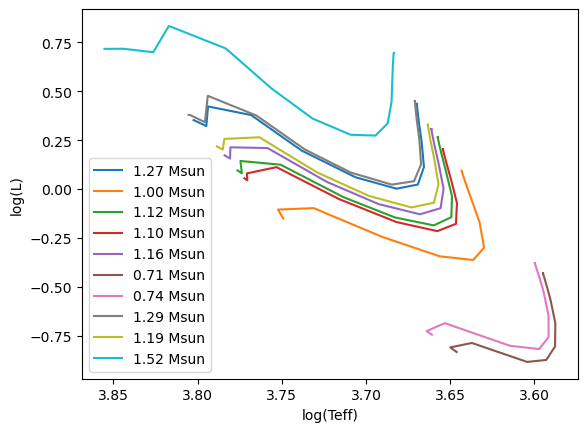

In [10]:
masses = salpeter_imf(0.7, 2.5, 10)

run_mesa_model(masses)

plot_hr_diagram(masses)

## NGC 4755

FOR MASS: 0.9988630409976494
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
partC.ipynb
report.tex
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:24:01
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.622443   4380.723  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.8416E+00   6.622443   0.265939 -99.000000  -6.324530 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071831      2
 3.6400E-05   0.145279   0.052756 -99.000000 -99.000000  -6.814988   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.622443   4380.724  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.7625E+00   6.622443   0.265939 -99.000000  -6.324530 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071831      3
 5.3680E-05   0.145279   0.052756 -99.000000 -99.000000  -6.814988   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.622443   4380.725  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.6833E+00   6.622443   0.265939 -99.000000  -6.324530 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:28:32
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.8416E+00   6.631017   0.070113 -99.000000  -6.063847 -99.000000   0.000000   0.280000   0.009381   0.020000   0.095227      2
 3.6400E-05   0.538342  -0.564471 -20.169010 -99.000000  -6.393179   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.7625E+00   6.631017   0.070113 -99.000000  -6.063847 -99.000000   0.000000   0.280000   0.009381   0.020000   0.095227      2
 5.3680E-05   0.538342  -0.564471 -19.867980 -99.000000  -6.393179   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.6833E+00   6.631017   0.070113 -99.000000  -6.063847 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:34:27
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.614502   4516.711  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.8416E+00   6.614502   0.318164 -99.000000  -6.447762 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067126      2
 3.6400E-05   0.033187   0.210311 -20.771070 -99.000000  -6.901293   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.614502   4516.701  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.7625E+00   6.614502   0.318164 -99.000000  -6.447762 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067126      2
 5.3680E-05   0.033187   0.210307 -20.771070 -99.000000  -6.901290   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.614502   4516.691  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.6833E+00   6.614502   0.318164 -99.000000  -6.447762 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:40:12
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.608056   4402.017  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.8416E+00   6.608056   0.284275 -99.000000  -6.481914 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071207      3
 3.6400E-05   0.090747   0.097850 -20.771070 -99.000000  -6.844763   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.608056   4402.008  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.7625E+00   6.608056   0.284275 -99.000000  -6.481914 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071207      3
 5.3680E-05   0.090747   0.097846 -20.293948 -99.000000  -6.844759   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.608056   4401.996  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.6833E+00   6.608056   0.284275 -99.000000  -6.481914 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:15:39
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.8416E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105614      2
 3.6400E-05   0.733897  -0.791470 -99.000000 -99.000000  -6.271971   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.7625E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105614      2
 5.3680E-05   0.733897  -0.791470 -20.169010 -99.000000  -6.271971   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.6833E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:20:58
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.8416E+00   6.635424   0.089063 -99.000000  -6.037344 -99.000000   0.000000   0.280000   0.009381   0.020000   0.092057      2
 3.6400E-05   0.507467  -0.506713 -99.000000 -99.000000  -6.427697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.7625E+00   6.635424   0.089063 -99.000000  -6.037344 -99.000000   0.000000   0.280000   0.009381   0.020000   0.092057      2
 5.3680E-05   0.507467  -0.506713 -99.000000 -99.000000  -6.427697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.6833E+00   6.635424   0.089063 -99.000000  -6.037344 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:25:11
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.8416E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.000000   0.000000   0.280000   0.009381   0.020000   0.103888      2
 3.6400E-05   0.717310  -0.766247 -20.169010 -99.000000  -6.286016   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.7625E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.000000   0.000000   0.280000   0.009381   0.020000   0.103888      2
 5.3680E-05   0.717310  -0.766247 -99.000000 -99.000000  -6.286016   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.6833E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:30:37
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.639902   3772.585  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.8416E+00   6.639902   0.021088 -99.000000  -5.936069 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101234      2
 3.6400E-05   0.644700  -0.696574 -20.470040 -99.000000  -6.321344   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.639902   3772.585  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.7625E+00   6.639902   0.021088 -99.000000  -5.936069 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101234      2
 5.3680E-05   0.644700  -0.696574 -19.992918 -99.000000  -6.321344   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.639902   3772.584  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.6833E+00   6.639902   0.021088 -99.000000  -5.936069 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:36:54
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.626071   3975.300  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.8416E+00   6.626071   0.133048 -99.000000  -6.166874 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087260      2
 3.6400E-05   0.409672  -0.381731 -99.000000 -99.000000  -6.514633   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.626071   3975.301  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.7625E+00   6.626071   0.133048 -99.000000  -6.166874 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087260      2
 5.3680E-05   0.409672  -0.381731 -20.169010 -99.000000  -6.514633   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.626071   3975.300  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.6833E+00   6.626071   0.133048 -99.000000  -6.166874 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:42:49
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.8416E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.000000   0.000000   0.280000   0.009381   0.020000   0.111830      2
 3.6400E-05   0.838365  -0.896253 -99.000000 -99.000000  -6.190786   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.7625E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.000000   0.000000   0.280000   0.009381   0.020000   0.111830      2
 5.3680E-05   0.838365  -0.896253 -99.000000 -99.000000  -6.190786   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.6833E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.

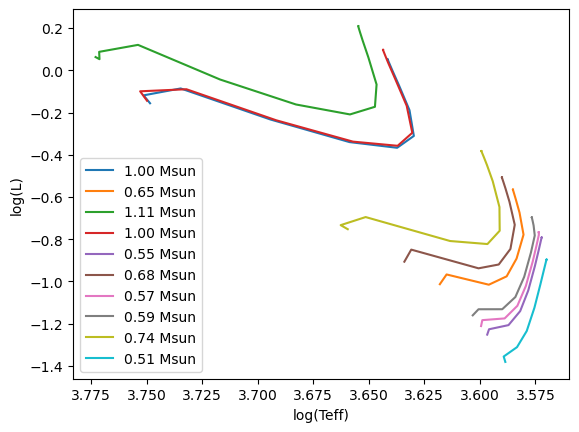

In [8]:
masses = salpeter_imf(0.5, 20, 10) # 100 stars

run_mesa_model(masses)

plot_hr_diagram(masses)

## Blanco 1 open cluster

FOR MASS: 0.5837630628567534
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
partC.ipynb
report.tex
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 01:06:46
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.639111   3765.980  -4.542836  -4.542836   0.583763   0.583763   0.700000   0.001010   0.280000  -2.944797    704      0
-4.8416E+00   6.639111   0.017710 -99.000000  -5.940337 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101848      3
 3.6400E-05   0.650206  -0.706374 -99.000000 -99.000000  -6.317081   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.639111   3765.979  -4.542836  -4.542836   0.583763   0.583763   0.700000   0.001010   0.280000  -2.944797    704      0
-4.7625E+00   6.639111   0.017710 -99.000000  -5.940337 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101848      3
 5.3680E-05   0.650206  -0.706375 -20.470040 -99.000000  -6.317081   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.639111   3765.979  -4.542836  -4.542836   0.583763   0.583763   0.700000   0.001010   0.280000  -2.944797    704      0
-4.6833E+00   6.639111   0.017710 -99.000000  -5.940337 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 04:34:46
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.477514   3614.503 -20.340701 -20.340701   0.292854   0.292854   0.700000   0.001010   0.280000  -5.616403    587      0
-4.8416E+00   5.477396   0.947135 -99.000000 -21.738567 -99.000000   0.000000   0.280000   0.009381   0.020000   0.160481      2
 3.6400E-05  -2.242521   1.081158 -99.000000 -99.000000  -7.528588   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.477514   3614.257 -20.340701 -20.340701   0.292854   0.292854   0.700000   0.001010   0.280000  -5.616403    587      0
-4.7625E+00   5.477396   0.947132 -99.000000 -21.738567 -99.000000   0.000000   0.280000   0.009381   0.020000   0.160481      2
 5.3680E-05  -2.242521   1.081034 -99.000000 -99.000000  -7.528444   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.477514   3613.968 -20.340701 -20.340701   0.292854   0.292854   0.700000   0.001010   0.280000  -5.616403    587      0
-4.6833E+00   5.477396   0.947129 -99.000000 -21.738567 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 05:44:30
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.693613   3673.557  -3.856205  -3.856205   0.400174   0.400174   0.700000   0.001010   0.280000  -1.973962    719      0
-4.8416E+00   6.693613  -0.202280 -99.000000  -5.252997 -99.000000   0.000000   0.280000   0.009381   0.020000   0.130953      2
 3.6400E-05   1.141205  -1.189519 -99.000000 -99.000000  -5.963981   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.693613   3673.557  -3.856205  -3.856205   0.400174   0.400174   0.700000   0.001010   0.280000  -1.973962    719      0
-4.7625E+00   6.693613  -0.202280 -99.000000  -5.252997 -99.000000   0.000000   0.280000   0.009381   0.020000   0.130953      2
 5.3680E-05   1.141205  -1.189519 -99.000000 -99.000000  -5.963981   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.693613   3673.557  -3.856205  -3.856205   0.400174   0.400174   0.700000   0.001010   0.280000  -1.973962    719      0
-4.6833E+00   6.693613  -0.202280 -99.000000  -5.252997 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 05:50:48
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.477514   3568.649 -20.305622 -20.305622   0.270708   0.270708   0.700000   0.001010   0.280000  -5.464938    585      0
-4.8416E+00   5.477423   0.913882 -99.000000 -21.703489 -99.000000   0.000000   0.280000   0.009381   0.020000   0.168801      2
 3.6400E-05  -2.176588   0.992473 -99.000000 -99.000000  -7.485968   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.477514   3568.436 -20.305622 -20.305622   0.270708   0.270708   0.700000   0.001010   0.280000  -5.464938    585      0
-4.7625E+00   5.477423   0.913880 -99.000000 -21.703489 -99.000000   0.000000   0.280000   0.009381   0.020000   0.168801      2
 5.3680E-05  -2.176588   0.992365 -99.000000 -99.000000  -7.485878   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.477514   3568.186 -20.305622 -20.305622   0.270708   0.270708   0.700000   0.001010   0.280000  -5.464938    585      0
-4.6833E+00   5.477423   0.913878 -99.000000 -21.703489 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 05:56:52
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.477476   3536.050 -20.282694 -20.282694   0.257179   0.257179   0.700000   0.001010   0.280000  -5.366486    590      0
-4.8416E+00   5.477391   0.892226 -99.000000 -21.680559 -99.000000   0.000000   0.280000   0.009381   0.020000   0.174449      2
 3.6400E-05  -2.133801   0.933220 -99.000000 -99.000000  -7.462111   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.477476   3535.857 -20.282694 -20.282694   0.257179   0.257179   0.700000   0.001010   0.280000  -5.366486    591      0
-4.7625E+00   5.477391   0.892225 -99.000000 -21.680559 -99.000000   0.000000   0.280000   0.009381   0.020000   0.174449      2
 5.3680E-05  -2.133801   0.933122 -99.000000 -99.000000  -7.462055   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.477476   3535.631 -20.282693 -20.282693   0.257179   0.257179   0.700000   0.001010   0.280000  -5.366486    591      0
-4.6833E+00   5.477391   0.892223 -99.000000 -21.680559 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 06:03:20
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.743341   3650.554  -3.298278  -3.298278   0.332995   0.332995   0.700000   0.001010   0.280000  -1.375873    727      0
-4.8416E+00   6.743341  -0.336308 -99.000000  -4.694020 -99.000000   0.000000   0.280000   0.009381   0.020000   0.149197      2
 3.6400E-05   1.460319  -1.468487 -99.000000 -99.000000  -5.733697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.743341   3650.554  -3.298278  -3.298278   0.332995   0.332995   0.700000   0.001010   0.280000  -1.375873    727      0
-4.7625E+00   6.743341  -0.336308 -99.000000  -4.694020 -99.000000   0.000000   0.280000   0.009381   0.020000   0.149197      2
 5.3680E-05   1.460319  -1.468487 -99.000000 -99.000000  -5.733697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.743341   3650.554  -3.298278  -3.298278   0.332995   0.332995   0.700000   0.001010   0.280000  -1.375873    727      0
-4.6833E+00   6.743341  -0.336308 -99.000000  -4.694020 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 06:10:38
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.718628   3662.249  -3.574396  -3.574396   0.365772   0.365772   0.700000   0.001010   0.280000  -1.681057    722      0
-4.8416E+00   6.718628  -0.268489 -99.000000  -4.970756 -99.000000   0.000000   0.280000   0.009381   0.020000   0.139591      2
 3.6400E-05   1.299476  -1.327294 -18.964890 -99.000000  -5.850107   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.718628   3662.249  -3.574396  -3.574396   0.365772   0.365772   0.700000   0.001010   0.280000  -1.681057    722      0
-4.7625E+00   6.718628  -0.268489 -99.000000  -4.970756 -99.000000   0.000000   0.280000   0.009381   0.020000   0.139591      2
 5.3680E-05   1.299476  -1.327294 -19.265920 -99.000000  -5.850107   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.718628   3662.249  -3.574396  -3.574396   0.365772   0.365772   0.700000   0.001010   0.280000  -1.681057    722      0
-4.6833E+00   6.718628  -0.268489 -99.000000  -4.970756 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 12:12:16
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.477476   3537.385 -20.283608 -20.283608   0.257707   0.257707   0.700000   0.001010   0.280000  -5.370416    590      0
-4.8416E+00   5.477391   0.893091 -99.000000 -21.681473 -99.000000   0.000000   0.280000   0.009381   0.020000   0.174221      2
 3.6400E-05  -2.135512   0.935605 -99.000000 -99.000000  -7.462983   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.477476   3537.185 -20.283607 -20.283607   0.257707   0.257707   0.700000   0.001010   0.280000  -5.370416    590      0
-4.7625E+00   5.477391   0.893090 -99.000000 -21.681473 -99.000000   0.000000   0.280000   0.009381   0.020000   0.174221      2
 5.3680E-05  -2.135512   0.935504 -99.000000 -99.000000  -7.462924   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.477476   3536.953 -20.283607 -20.283607   0.257707   0.257707   0.700000   0.001010   0.280000  -5.370416    590      0
-4.6833E+00   5.477391   0.893088 -99.000000 -21.681473 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 12:21:58
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.694788   3679.368  -3.852000  -3.852000   0.409708   0.409708   0.700000   0.001010   0.280000  -2.014699    712      0
-4.8416E+00   6.694788  -0.193597 -99.000000  -5.248831 -99.000000   0.000000   0.280000   0.009381   0.020000   0.129089      2
 3.6400E-05   1.126052  -1.169407 -19.566950 -99.000000  -5.977667   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.694788   3679.368  -3.852000  -3.852000   0.409708   0.409708   0.700000   0.001010   0.280000  -2.014699    712      0
-4.7625E+00   6.694788  -0.193597 -99.000000  -5.248831 -99.000000   0.000000   0.280000   0.009381   0.020000   0.129089      2
 5.3680E-05   1.126052  -1.169407 -99.000000 -99.000000  -5.977667   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.694788   3679.368  -3.852000  -3.852000   0.409708   0.409708   0.700000   0.001010   0.280000  -2.014699    712      0
-4.6833E+00   6.694788  -0.193597 -99.000000  -5.248831 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 12:34:12
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.651197   3736.249  -4.399646  -4.399646   0.558417   0.558417   0.700000   0.001010   0.280000  -2.803823    707      0
-4.8416E+00   6.651197  -0.014651 -99.000000  -5.797081 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105178      2
 3.6400E-05   0.728385  -0.784865 -99.000000 -99.000000  -6.276881   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.651197   3736.249  -4.399646  -4.399646   0.558417   0.558417   0.700000   0.001010   0.280000  -2.803823    707      0
-4.7625E+00   6.651197  -0.014651 -99.000000  -5.797081 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105178      2
 5.3680E-05   0.728385  -0.784865 -19.867980 -99.000000  -6.276881   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.651197   3736.249  -4.399646  -4.399646   0.558417   0.558417   0.700000   0.001010   0.280000  -2.803823    707      0
-4.6833E+00   6.651197  -0.014651 -99.000000  -5.797081 -99.

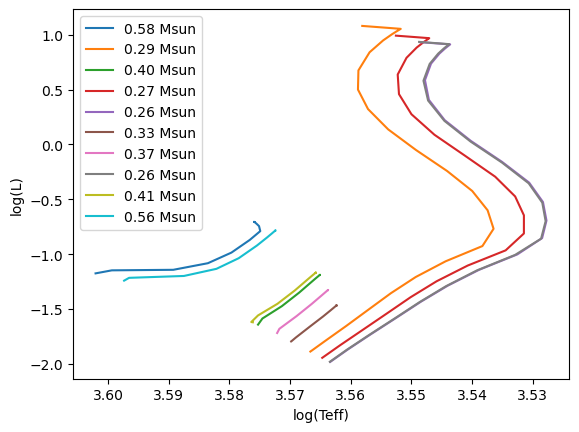

In [9]:
masses = salpeter_imf(0.2, 8, 10) # 644 stars

run_mesa_model(masses)

plot_hr_diagram(masses)